In [465]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
#%matplotlib widget, remove below if used
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [466]:
def prepare_profile_data(files):
    # spin data structure changed to two spin readouts therefore spin_data -> spin_data[0]
    # prepare the data into a data frame using the calibration Akio has performed
    df = pd.DataFrame()
    spin_list = [] # a list for the spin_sum
    cant_pos_list_x, cant_pos_list_y, cant_pos_list_z = [[] for  x in range(3)] # save the positions of the cantielever
    spin_length = files[0].spin_data[0]
    spin_down_size_factor = len(spin_length)/len(files[0].xyz[0]) # 10 for normal operation, but can be different
    
    for i in tqdm(range(len(files))):
        spin = np.zeros(len(files[0].xyz[0]))
        spin_temp = files[i].spin_data[0]
        for j in range(len(files[i].xyz[0])):
            spin[j]=np.average(spin_temp[int(spin_down_size_factor)*j: int(spin_down_size_factor)*j+ int(spin_down_size_factor-1)]) # average down to 5000 in order to match spin with the cantilever position.    
        spin_list.append(spin)
        cant_pos_list_x.append(files[i].cant_pos[0])
        cant_pos_list_y.append(files[i].cant_pos[1])
        cant_pos_list_z.append(files[i].cant_pos[2])
    df["SPIN_SUM"] = spin_list 
    df["CANT_POS_X"] = cant_pos_list_x
    df["CANT_POS_Y"] = cant_pos_list_y
    df["CANT_POS_Z"] = cant_pos_list_z
    df["CANT_FREQ"] = files[0].cant_freq
    df["FS"] = files[0].fsamp
    
    # use calibration
    ## applies calibration assuming x and y have the same
    df["CANT_POS_X_cal"] = df["CANT_POS_X"].apply(lambda element: voltage_to_x_position(element))  
    df["CANT_POS_Y_cal"] = df["CANT_POS_Y"].apply(lambda element: voltage_to_x_position(element)) 
    df["CANT_POS_Z_cal"] = df["CANT_POS_Z"].apply(lambda element: voltage_to_z_position(element))
    
    
    # differentiate the power to get dP/dx plots
    df["SPIN_SUM_diff"] = df["SPIN_SUM"].apply(lambda element: np.diff(element)) # 
    
    return df

In [467]:
def extract_in_out_movement(df,fn,detector="SPIN",axis="X",avg_rng=1):
    freq=np.mean(df.CANT_FREQ)
    fs=np.mean(df.FS)
    factor = int(fs/(2*freq))
    start = int(factor/2)
    #print(start)
    end= len(df["%s_SUM_diff" %detector][fn])-start
    #print(end)
    data_x = np.zeros(factor)
    data_x2 = np.zeros(factor)
    data_y = np.zeros(factor)
    data_y2 = np.zeros(factor)
    i=0
    for k in np.arange(start,end,factor):
        i+=1
        averaged_series = pd.Series(df["%s_SUM_diff" %detector][fn]).ewm(span=avg_rng,adjust=True).mean()
        data_y_temp = averaged_series[k:k+factor]/averaged_series.mean()#df["QPD_SUM_diff"][0][1300:-1400] # give y data 
        data_x_temp = df["CANT_POS_%s_cal" %axis][fn][k:k+factor]# give x data
        if(np.sum(data_y_temp)<0): data_y_temp = -data_y_temp
        if((i % 2) == 0):
            data_y = np.add(data_y,np.array(data_y_temp))
            data_x = np.add(data_x,data_x_temp)
        else:
            data_y2 = np.add(data_y2,np.array(data_y_temp))  
            data_x2 = np.add(data_x2,data_x_temp)
    data_x = data_x/(0.5*(i-1)) # factor automatic
    data_x2 = data_x2/(0.5*(i+1)) # factor automatic +-1
    data_y = data_y
    data_y2 = data_y2
    #plt.plot(data_x,data_y)
    return data_y,data_y2,data_x,data_x2        

In [468]:
def fit_dP_dx(data_x,data_y,data_y_error=None,plot=False,logscale=False):
    if(data_y_error==None): data_y_error = np.sqrt(np.abs(data_y)+0.001) # give y uncertainty
    def chisquare_gaussian_beam(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian_beam,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    arg_maxy = np.array(data_x)[np.argmax(np.array(data_y))]
    #print(maxy,np.sum(data_y))
    #plt.plot(data_x,data_y)
    #plt.show()
    try:
        m=Minuit(chisquare_gaussian_beam, 
                 area = 2*np.max(data_y), # set start parameter
                 #limit_area= (np.sum(data_y)/200,np.sum(data_y)), # if you want to limit things
                 #fix_area = "False", # you can also fix it
                 mean = arg_maxy,
                 #fix_mean = "True",
                 #limit_mean = (arg_maxy-20, arg_maxy+20),
                 sigma = 125,
                 #limit_sigma=(100,4),
                 #fix_sigma="True",
                 constant = 0,
                 #fix_constant="True",
                 errordef = 1,
                 print_level=0,
                 pedantic=False)
        #print('Now proceed with the fit.')
        m.migrad()
        #print()
        #m.minos()#, if you need fancy mapping
        chisquare=m.fval
    except:print("Fit did not converge")   
    #print(chisquare)
    #print(m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"])
    print(np.max(data_y))    
    if(plot==True):
        plt.plot(data_x,data_y)
        plt.plot(data_x,gaussian_beam(data_x,params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]))
        if(logscale==True):
            plt.yscale("log")
            plt.ylim(np.max(data_y)/10000,np.max(data_y)*10)    
        #plt.show()
    return m

In [469]:
def extract_waist_data(df,up_or_low = "up",axis="Y",detector="SPIN",avg_rng=10,sub_sample=False,plot=False,logscale=True,save=True):
    sigma_list,sigma_err_list,mean_list,chi2_list,fit_list = [[] for x in range(5)]
    if(sub_sample==True):length=10
    else: length=len(df)
    for j in tqdm(np.arange(0,length,1)):
        data_y,data_y2,data_x,data_x2 = extract_in_out_movement(df,j,detector,axis,avg_rng=1)
        if(up_or_low=="up"):m = fit_dP_dx(data_x,data_y,plot=plot,logscale=logscale)
        if(up_or_low=="low"):m = fit_dP_dx(data_x2,data_y2,plot=plot,logscale=logscale)
        sigma_list.append(m.values["sigma"])
        sigma_err_list.append(m.errors["sigma"])
        mean_list.append(m.values["mean"])
        chi2_list.append(m.fval/(len(data_x)-3))
        fit_list.append(m)
    if(save==True):
        if(axis=="X"):fname=fname_x
            
        if(axis=="Y"):fname=fname_y
        np.save(folder+fname+"_sigma_list.npy", sigma_list)
        np.save(folder+fname+"_mean_list.npy", mean_list)
        np.save(folder+fname+"_chi2_list.npy", chi2_list)
    print(np.sum(data_y),m.values["area"],m.values["mean"],m.values["sigma"])
    return sigma_list,sigma_err_list, mean_list, chi2_list,fit_list

In [546]:
def make_x_axis_for_beam_profile(df):
    # reads in the z-position of each data set and provides an x_axis for the plots
    x_axis = []
    for i in range(len(df)):
        x_axis.append(df["CANT_POS_Z_cal"][i].mean())
    return x_axis

In [551]:
folder="/home/data_transfer/data_from_windows/20220222/BeamProfile_Y/"
files = load_dir(folder, file_prefix = "B", max_file=100)
#files_x = load_dir(folder, file_prefix = fname_x, max_file=100)


100%|██████████| 55/55 [00:02<00:00, 19.25it/s]

55  files in folder
55  files loaded


In [552]:
df_x = prepare_profile_data(files)

100%|██████████| 55/55 [00:05<00:00,  9.38it/s]


In [553]:
df_x

,SPIN_SUM,CANT_POS_X,CANT_POS_Y,CANT_POS_Z,CANT_FREQ,FS,CANT_POS_X_cal,CANT_POS_Y_cal,CANT_POS_Z_cal,SPIN_SUM_diff
0,"[0.0026446689592136076, 0.041923435380773165, ...","[1.993705040286128, 1.9940100320685115, 1.9933...","[5.21377768429492, 5.213941911185466, 5.213808...","[0.030321466485399063, 0.03071260268572072, 0....",1.0,5000.0,"[100.59519326440247, 100.61057048438174, 100.5...","[262.946339282838, 262.95461935190315, 262.947...","[0.3032146648539906, 0.3071260268572072, 0.300...","[0.03927876642155956, 0.004285114374370305, -0..."
1,"[-0.4086307228824984, 0.010788993838795606, 0....","[1.9935720951502376, 1.9937128605882772, 1.993...","[5.213957551841878, 5.2137307623257145, 5.2138...","[0.030681311789694743, 0.030626552721649346, 0...",1.0,5000.0,"[100.5884903736433, 100.5955875520961, 100.573...","[262.9554079299179, 262.94397354879527, 262.94...","[0.30681311789694743, 0.3062655272164934, 0.30...","[0.419419716721294, 0.03285544082404901, 0.000..."
2,"[-0.3853798453593913, 0.01678641557640979, 0.0...","[1.9934626109206417, 1.9937363214945427, 1.993...","[5.213973192498395, 5.214207802342467, 5.21389...","[0.12977957980875238, 0.12999079335856273, 0.1...",1.0,5000.0,"[100.5829703459573, 100.59677041516781, 100.58...","[262.95619650793793, 262.9680251780529, 262.95...","[1.2977957980875237, 1.2999079335856272, 1.297...","[0.4021662609358011, 0.03282067316604616, 0.00..."
3,"[-0.43818324154681076, 0.015204486944586386, 0...","[1.993806704213971, 1.9935720951499754, 1.9935...","[5.21407485676398, 5.214559717108391, 5.214074...","[0.2303250530490426, 0.22993391683876158, 0.22...",1.0,5000.0,"[100.60031900441481, 100.58849037363008, 100.5...","[262.9613222649787, 262.9857681832161, 262.961...","[2.303250530490426, 2.2993391683876157, 2.2994...","[0.45338772849139714, 0.03688848965087184, 0.0..."
4,"[-0.357756934328162, 0.028190208794589864, 0.0...","[1.993587735753842, 1.9939552899538024, 1.9933...","[5.213629098059256, 5.213253722309297, 5.21387...","[0.32789789327788227, 0.3281951568055984, 0.32...",1.0,5000.0,"[100.58927894899557, 100.60781047054323, 100.5...","[262.93884779171043, 262.9199219195545, 262.95...","[3.2789789327788226, 3.281951568055984, 3.2785...","[0.3859471431227519, 0.030256558083720197, 0.0..."
5,"[-0.4042239218019828, 0.02300982711946683, 0.0...","[1.993947469651776, 1.993626837264755, 1.99397...","[5.2142312633267, 5.214270364967698, 5.2145675...","[0.42851377644239114, 0.4280913493085702, 0.42...",1.0,5000.0,"[100.60741618285579, 100.59125038747216, 100.6...","[262.96920804505567, 262.9711794900909, 262.98...","[4.2851377644239115, 4.280913493085701, 4.2802...","[0.4272337489214496, 0.03442867755241416, 0.00..."
6,"[-0.34747439733563584, 0.038307598512953865, 0...","[1.9937206808909758, 1.993697219984135, 1.9937...","[5.214262544639593, 5.214207802342664, 5.21403...","[0.5277293960105108, 0.5278076232610462, 0.527...",1.0,5000.0,"[100.59598183981743, 100.59479897671672, 100.5...","[262.97078520108863, 262.9680251780629, 262.95...","[5.277293960105108, 5.278076232610462, 5.27557...","[0.3857819958485897, 0.030821532608282208, 0.0..."
7,"[-0.36980393165254494, 0.04075002678818611, 0....","[1.9938067042133454, 1.993845805724622, 1.9937...","[5.2143485682485995, 5.213816785935536, 5.2140...","[0.6259124208020708, 0.6258498389983216, 0.625...",1.0,5000.0,"[100.60031900438327, 100.60229044287819, 100.5...","[262.97512238010626, 262.948310727854, 262.957...","[6.259124208020707, 6.258498389983216, 6.25388...","[0.41055395844073106, 0.03200363312996815, 0.0..."
8,"[-0.35870435406749085, 0.04436586366452022, 0....","[1.9941507975069488, 1.9938692666303475, 1.993...","[5.214278185295166, 5.214067036435734, 5.21365...","[0.7261606510049896, 0.7259025010474678, 0.725...",1.0,5000.0,"[100.6176676628546, 100.60347330592266, 100.59...","[262.9715737790611, 262.96092797596935, 262.94...","[7.261606510049896, 7.259025010474677, 7.25714...","[0.40307021773201107, 0.03191671398001336, 0.0..."
9,"[-0.3697865484359667,

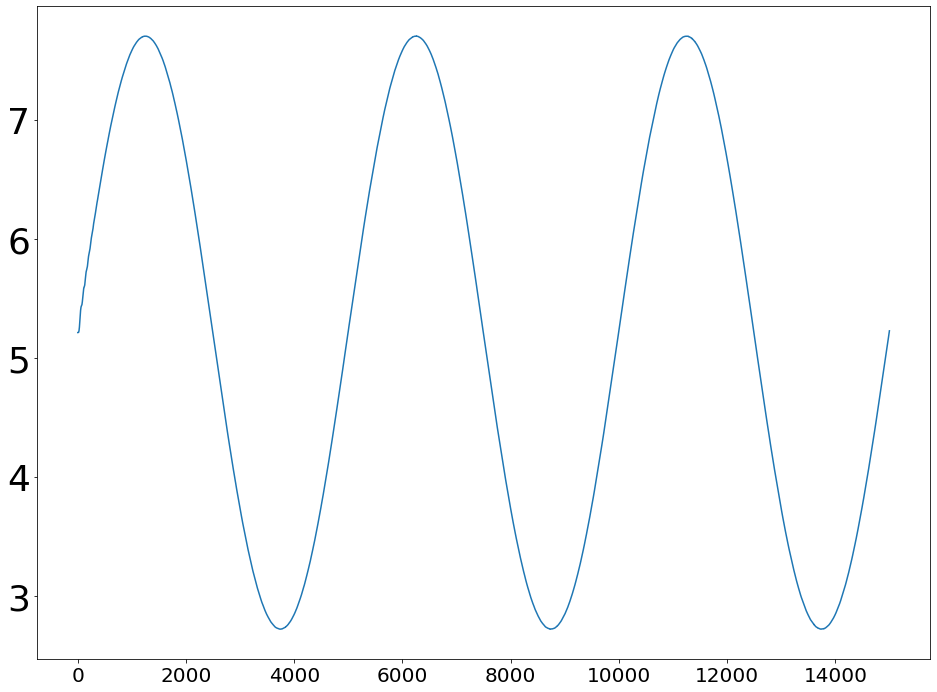

In [557]:
plt.plot(df_x.CANT_POS_Y[2])


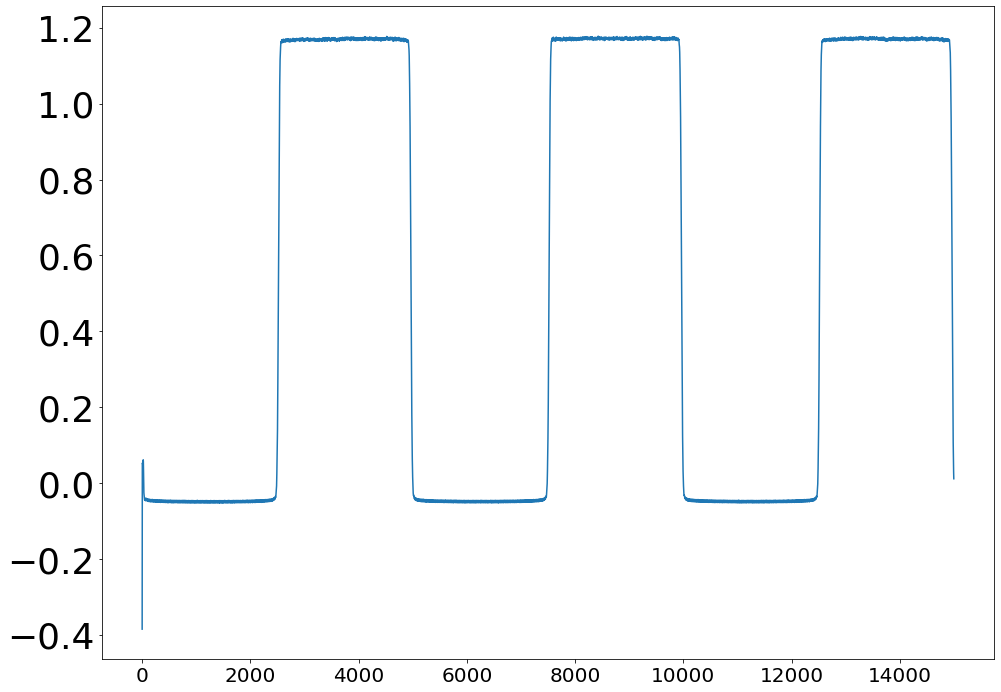

In [555]:
plt.plot(df_x.SPIN_SUM[2])


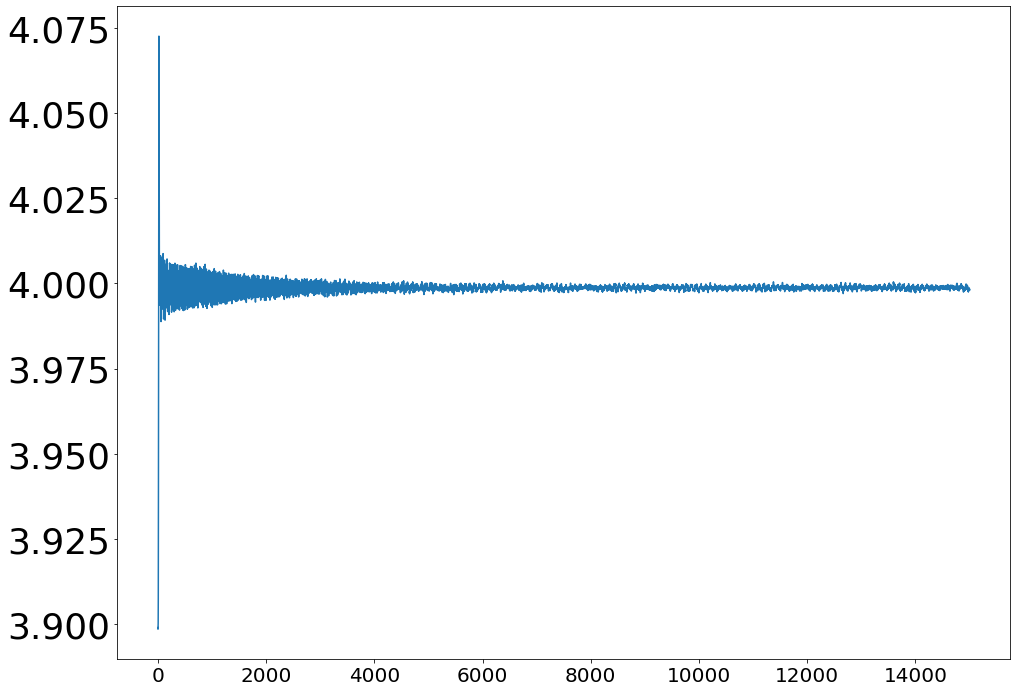

In [556]:
plt.plot(df_x.CANT_POS_Z[40])

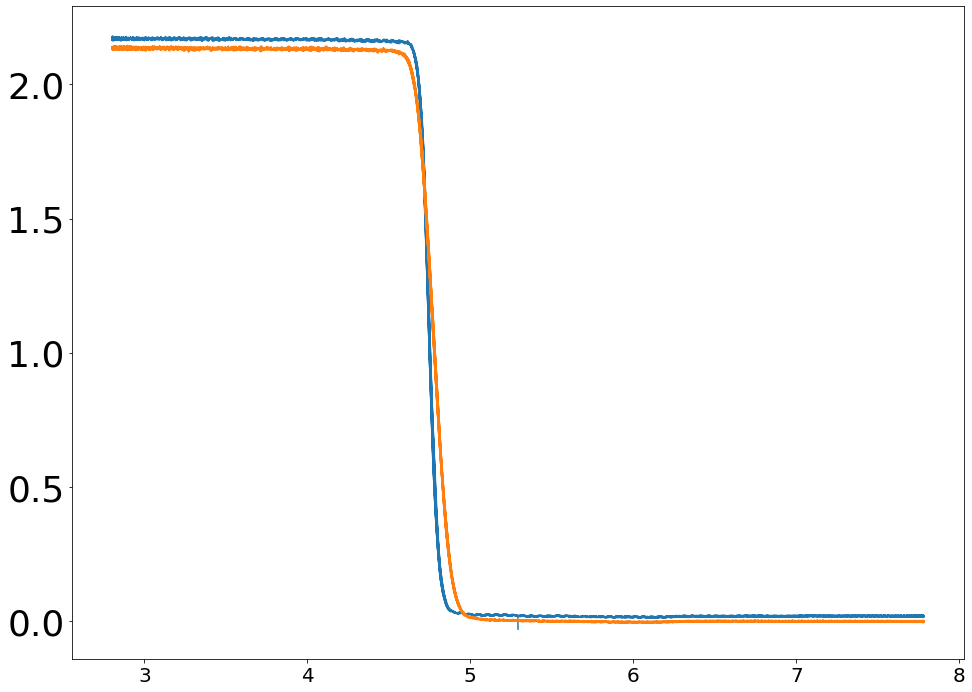

In [73]:
#plt.plot(df_x.SPIN_SUM[0])
plt.plot(df_x.CANT_POS_X[40],df_x.SPIN_SUM[40])
plt.plot(df_x.CANT_POS_X[0],df_x.SPIN_SUM[0])


  2%|▏         | 2/100 [00:00<00:06, 14.42it/s]

197910.14260350552
66507.91303957847
116751.10113143109


  5%|▌         | 5/100 [00:00<00:08, 11.59it/s]

70498.36017117283
113828.74963935162
84464.78933620008


  9%|▉         | 9/100 [00:00<00:06, 13.19it/s]

82274.46648722836
104938.92875022186
58509.17550793491
174712.00188097882


 13%|█▎        | 13/100 [00:00<00:05, 14.73it/s]

58162.67962411078
138636.04952651152
109504.3041189292
252198.1238584397


 17%|█▋        | 17/100 [00:01<00:05, 15.95it/s]

421462.4001348717
232661.90843894606
122137.24858373617
177380.4569679231


 21%|██        | 21/100 [00:01<00:05, 15.45it/s]

374159.3447163181
378021.7708131269
632383.4340794391
241672.24300862546


 25%|██▌       | 25/100 [00:01<00:04, 15.72it/s]

26588076.001174513
199110.5131076565
496832.80925744656
301898.20793982816


 29%|██▉       | 29/100 [00:01<00:04, 16.63it/s]

1073394.979608472
624825.8483715222
339278.4439688527
252176.7696246684


 33%|███▎      | 33/100 [00:02<00:04, 15.78it/s]

314777.5221523991
1298702.6881768364
2965297.056584142
5055080.252280494


 37%|███▋      | 37/100 [00:02<00:03, 16.62it/s]

225270.9457423007
1159426.2837440826
178425483.7692425
7018632.163820049
1301786.2400884267


 40%|████      | 40/100 [00:02<00:03, 15.97it/s]

535416.1755733356
300972.97052239836


 44%|████▍     | 44/100 [00:02<00:03, 14.28it/s]

198600.2655146196
1469781.7882260566
2094080.9242824418
551656.5425631672


 48%|████▊     | 48/100 [00:03<00:03, 15.25it/s]

503776.52089540724
130898993.22302502
463807.39593600726
545825.1263153211


 52%|█████▏    | 52/100 [00:03<00:03, 14.76it/s]

3793710.5988855707
259992.64323328505
238278.16058450023


 54%|█████▍    | 54/100 [00:03<00:02, 15.71it/s]

272743.4283463679
244890.33161379726


 56%|█████▌    | 56/100 [00:03<00:03, 12.70it/s]

279565.8223940036
124691.41614586065
80930.8453837052


 58%|█████▊    | 58/100 [00:03<00:03, 13.42it/s]

267365.78883393074
173767.6949659317


 60%|██████    | 60/100 [00:04<00:03, 11.23it/s]

76648.01883070312
57291.41292364795


 62%|██████▏   | 62/100 [00:04<00:05,  7.59it/s]

87067.85687208502
50594.82960327078


 64%|██████▍   | 64/100 [00:05<00:05,  6.94it/s]

47173.42974650417


 66%|██████▌   | 66/100 [00:05<00:04,  7.22it/s]

68167.84344578485
68914.38767856974


 68%|██████▊   | 68/100 [00:05<00:04,  7.09it/s]

51704.26054798006
54469.26675496472


 71%|███████   | 71/100 [00:05<00:03,  8.45it/s]

46944.11704401761
33856.09672880701
34136.4248171585


 74%|███████▍  | 74/100 [00:06<00:02,  9.95it/s]

28437.231861185588
25998.618568045044
25091.174952899495


 76%|███████▌  | 76/100 [00:06<00:03,  6.87it/s]

28258.01737488572
24580.368949162876
22976.102439221933


 79%|███████▉  | 79/100 [00:06<00:02,  8.02it/s]

20235.931508634538
17500.61341078174


 82%|████████▏ | 82/100 [00:07<00:02,  7.84it/s]

15801.74085389149
17262.711015891786
18083.71683965823


 84%|████████▍ | 84/100 [00:07<00:01,  9.29it/s]

15470.300737491414
12342.367567024148
12121.323158967934
15125.27718261167


 90%|█████████ | 90/100 [00:07<00:00, 12.00it/s]

11756.028430965303
12554.22770154539
12309.784545348291
11524.182938166736


 93%|█████████▎| 93/100 [00:07<00:00, 13.61it/s]

10485.829728965924
10125.421867562236
8901.148868042665
9612.246762025072


 97%|█████████▋| 97/100 [00:08<00:00, 12.53it/s]

9320.52502405825
8122.047115610145
8089.369383130111


100%|██████████| 100/100 [00:08<00:00, 11.70it/s]

7082.631480701815
8345.867128810281
7371.638494423776
230620.40104488062 7602.827270343677 254.48062269508256 5.45500613470757


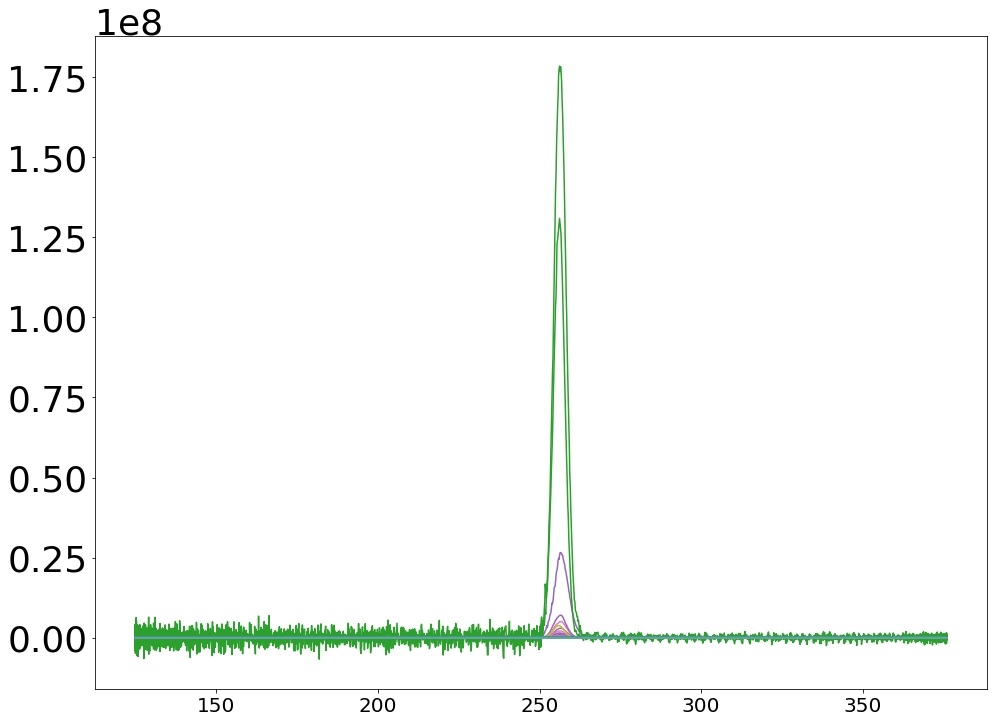

In [23]:
xdat=extract_waist_data(df_x,up_or_low="low",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=True,logscale=False,save=False)

(-50.0, 50.0)

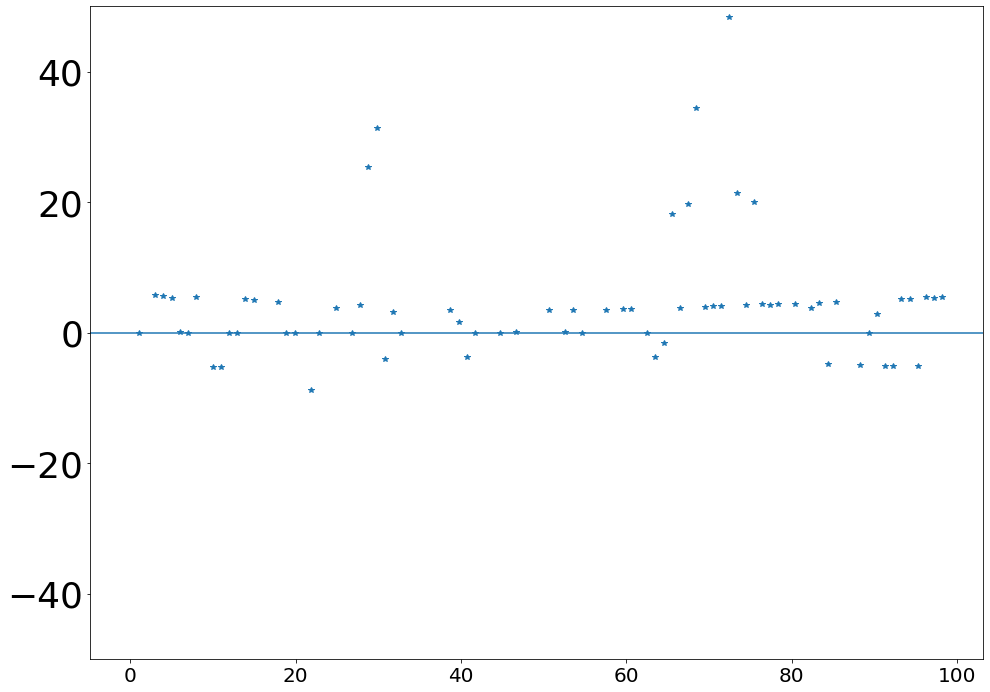

In [26]:
x = make_x_axis_for_beam_profile(df_x)
plt.plot(x,xdat[0],ls="",marker="*")
plt.axhline(0)
plt.ylim([-50,50])

In [11]:
data_y,data_y2,data_x,data_x2 = extract_in_out_movement(df=df_x,fn=1,axis="X",avg_rng=1)

2240.896270274295


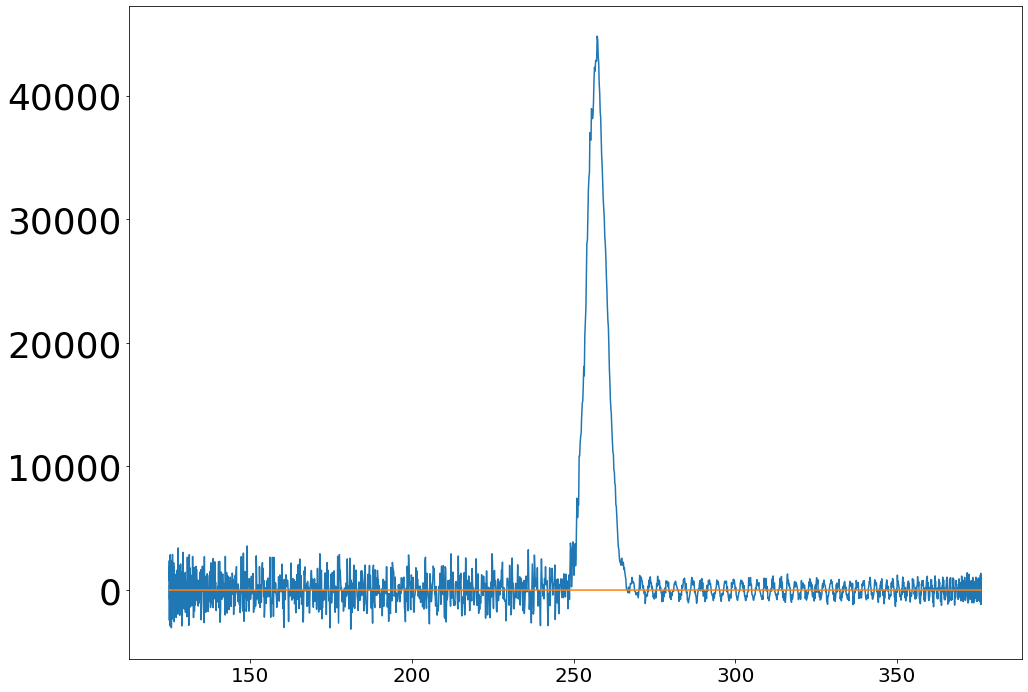

In [12]:
data_y_error = np.sqrt(np.abs(data_y)+0.001)# give y data 
def chisquare_gaussian_beam(area,mean,sigma,constant):
    return chisquare_1d(function=gaussian_beam,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
arg_maxy = np.array(data_x)[np.argmax(np.array(data_y))]
m=Minuit(chisquare_gaussian_beam, 
         area = 25000, # set start parameter
         #limit_area= (np.sum(data_y)/200,np.sum(data_y)), # if you want to limit things
         #fix_area = "False", # you can also fix it
         mean = 250,
         #fix_mean = "True",
         #limit_mean = (arg_maxy-20, arg_maxy+20),
         sigma = 200,
         #limit_sigma=(1,4),
         #fix_sigma="True",
         constant = 0,
         #fix_constant="True",
         errordef = 1,
         print_level=0,
         pedantic=False)
m.migrad()
print(m.values["sigma"])

chisquare=m.fval

plt.plot(data_x,data_y)
plt.plot(data_x,gaussian_beam(data_x,params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]))


257.1627164389632
2.1028144654222727
257.0705930751774
2.104091212207576
257.10578323405804
2.106938067268419
257.0972008471669
2.106600798399623
257.11341426586034
2.10757316018426
257.0767000951619
2.1072750078780915
257.07198767259746
2.108711621227667
257.058846387688
2.112963950018326
256.88535672184463
2.114324276169539
256.99769380681323
2.1156124838156445
256.9561964032221
2.113459620610756
256.95912400370605
2.114724078244653
256.92547185726795
2.1152590982623622
256.90096645615387
2.1158693951271497
256.870768505508
2.117401412776213
256.8524451649843
2.118239961153712
256.8313253742076
2.1164139681091374
256.7871763782514
2.118164761635543
256.7459541100221
2.1191546025448327
256.707808504122
2.118560053449363
256.669390542201
2.119631236592233
256.63151679725496
2.1208116793997496
256.6049288115519
2.1221233957671957
256.5792771890546
2.1224950177050714
256.545809039305
2.1223734723492265
256.5029257237627
2.1232323780161573
256.4869920598265
2.1234830816818957
256.45805492

(240.0, 280.0)

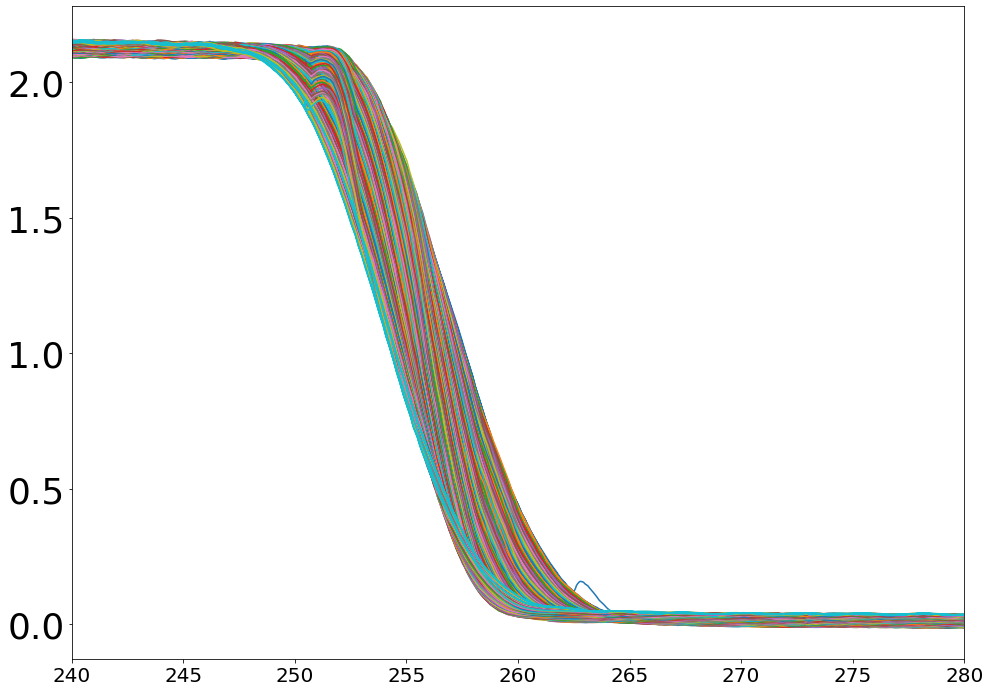

In [25]:
for i in range(100):
    
    def chisquare_gaussian_cdf(amp,mean,sigma,constant):
        return chisquare_1d(function=gaussian_cdf,functionparams=[amp,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

    def gaussian_cdf(data_x,params=list):
        # for normalization a 1/sigma could be needed
        return params[0]*0.5*(1+scipy.special.erf((data_x-params[1])/(np.sqrt(2)*params[2])))+params[3]

    data_x = df_x.CANT_POS_X[i] # give x data
    data_y = df_x.SPIN_SUM[i]# give y data 
    data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty  
    #plt.plot(voltage_to_x_position(data_x),data_y)

    m=Minuit(chisquare_gaussian_cdf, 
     amp = -1.6, # set start parameter
     #limit_area= (limit_lower,limit_upper) # if you want to limit things
     #limit_amp = (-3e-9,-1.5e-9), # you can also fix it
     mean = 4,
     #fix_mean = "True",
     #limit_mean = (3500,4500),
     sigma = 3e-1,
     limit_sigma=(0,1),        
     constant = 1.6,
     #fix_constant="True",
     errordef = 1,
     print_level=0
             ,pedantic=False)
     #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    print(voltage_to_x_position(m.values["mean"]))
    print(m.values["constant"])

    plt.plot(voltage_to_x_position(data_x),data_y)
    #plt.yscale("log")
    #plt.plot(voltage_to_x_position(data_x),gaussian_cdf(data_x,params=[m.values["amp"],(m.values["mean"]),m.values["sigma"],m.values["constant"]]),alpha=1)
    #plt.show() 
plt.xlim([240,280])

In [189]:
imgs = load_img_files("/home/data_transfer/slowcontrol_data/ImageAnalysis/focal_position_rebuild_20220208/*img1*")

/home/data_transfer/slowcontrol_data/ImageAnalysis/focal_position_rebuild_20220208/img1.bmp 0


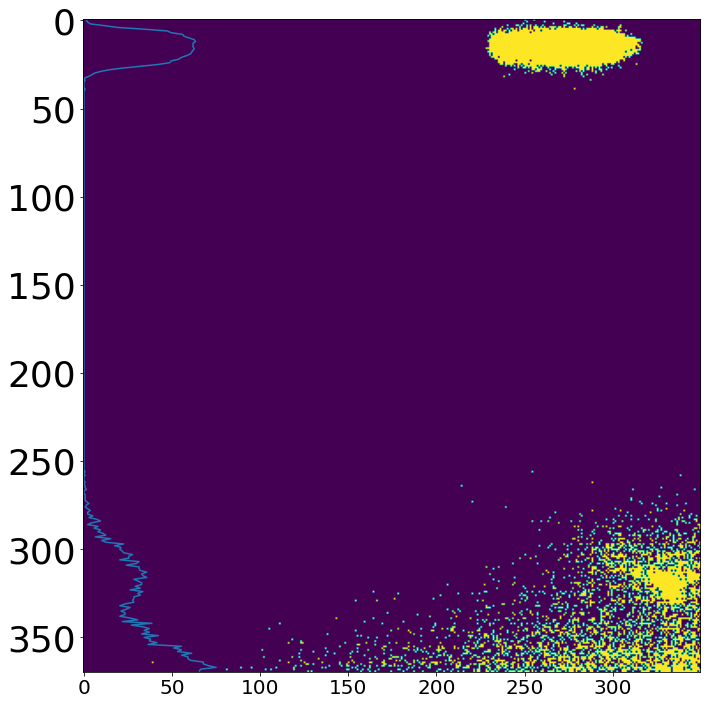

In [226]:
plt.imshow(threshold_image(imgs[0],95,255)[:,0:350])
plt.plot(np.mean(threshold_image(imgs[0],95,255)[:,0:350],axis=1),range(370))

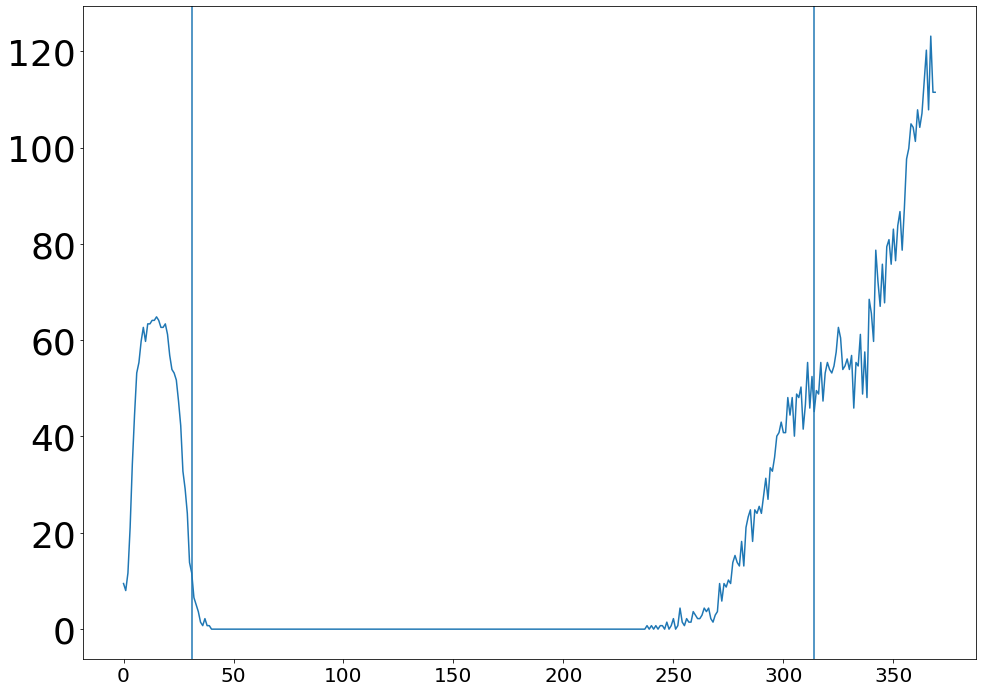

In [228]:
plt.plot(np.mean(threshold_image(imgs[0],90,255)[:,0:350],axis=1))
plt.axvline(314)
plt.axvline(31)

In [223]:
13.333333333333334*(314-32)


3760.0

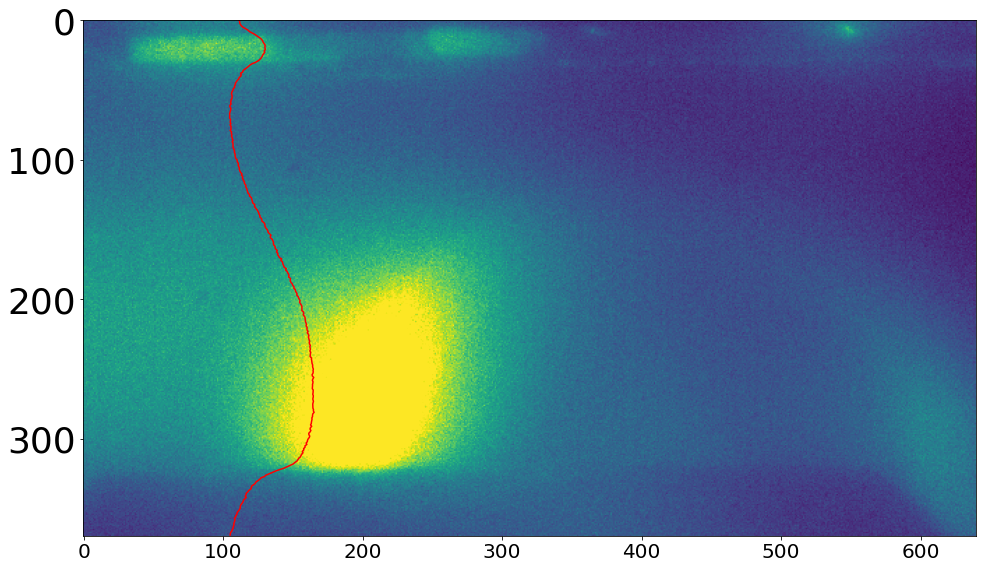

In [127]:
img = threshold_image(imgs[0],0,120)
img=imgs[0]
plt.imshow(img)
plt.plot(np.mean(img,axis=1),range(370),color="red")


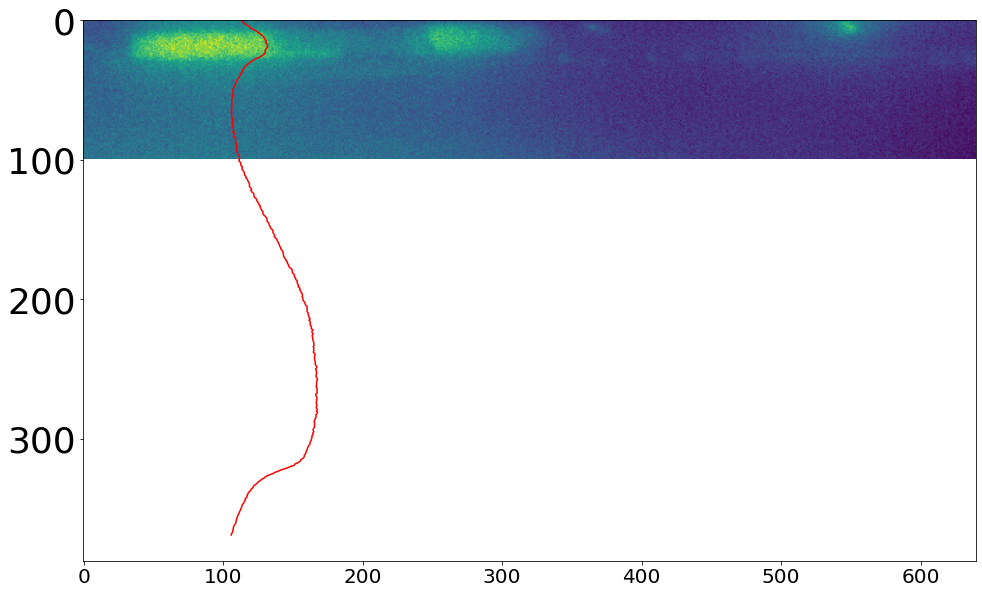

In [137]:
img = threshold_image(imgs[0],0,120)
img=imgs[1]
plt.imshow(img[0:100])
plt.plot(np.mean(img,axis=1),range(370),color="red")


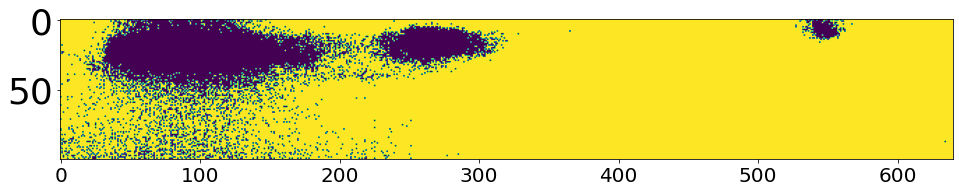

In [154]:
plt.imshow(threshold_image(imgs[0][0:100],65,135))



In [165]:
for i in range(3):
    print(np.argmax(np.mean(imgs[i][0:50],axis=1)))

21
19
16


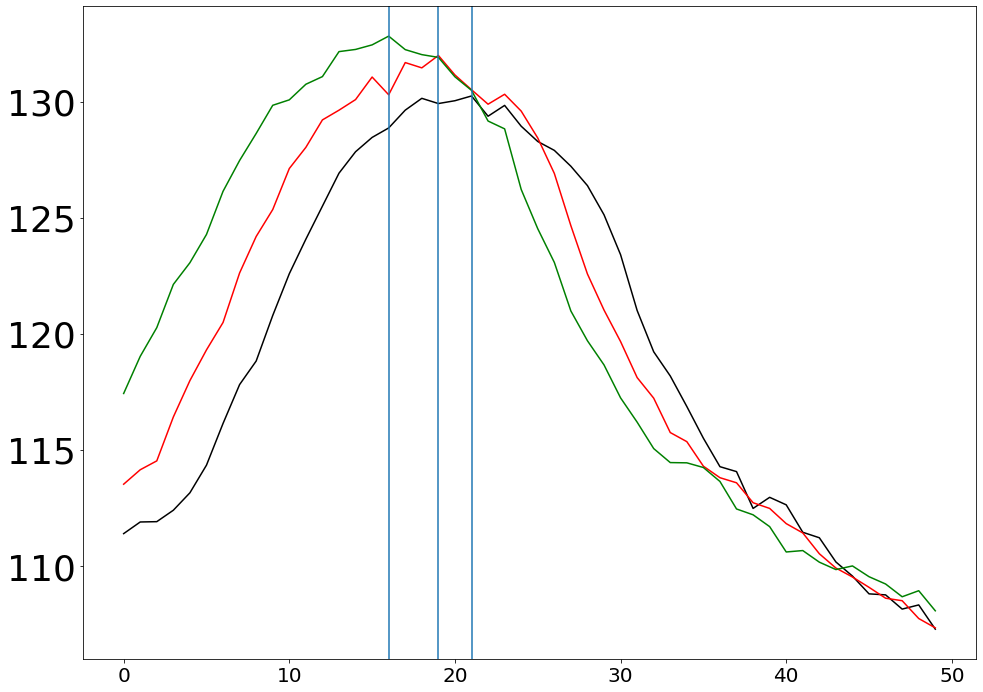

In [166]:
plt.plot(np.mean(imgs[0][0:50],axis=1),color="black")
plt.plot(np.mean(imgs[1][0:50],axis=1),color="red")
plt.plot(np.mean(imgs[2][0:50],axis=1),color="green")

plt.axvline(21)
plt.axvline(19)
plt.axvline(16)

plt.show()

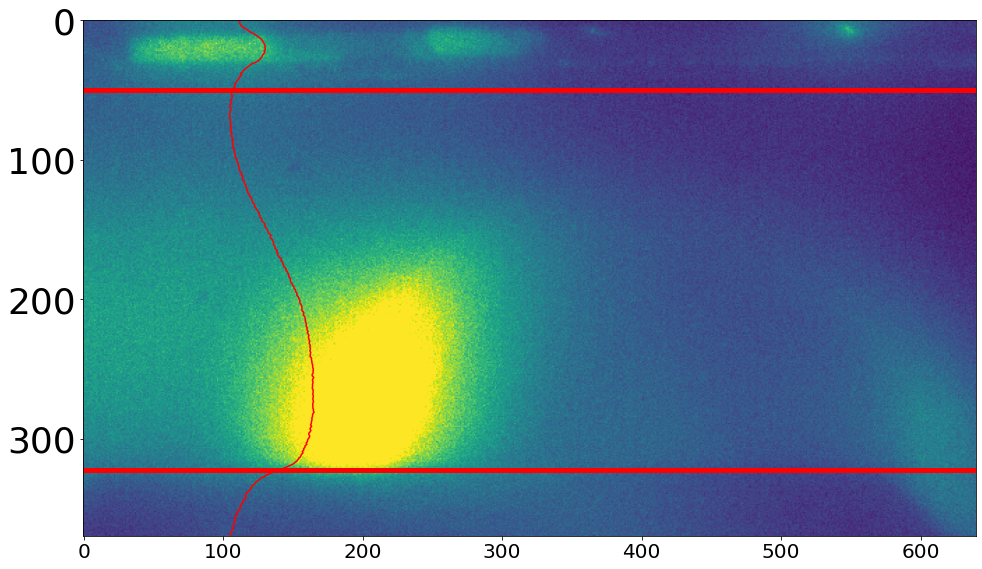

In [186]:
img = threshold_image(imgs[0],0,120)
img=imgs[0]
plt.imshow(img)
plt.plot(np.mean(img,axis=1),range(370),color="red")
plt.axhline(50,color="red",linewidth=5)
plt.axhline(322,color="red",linewidth=5)

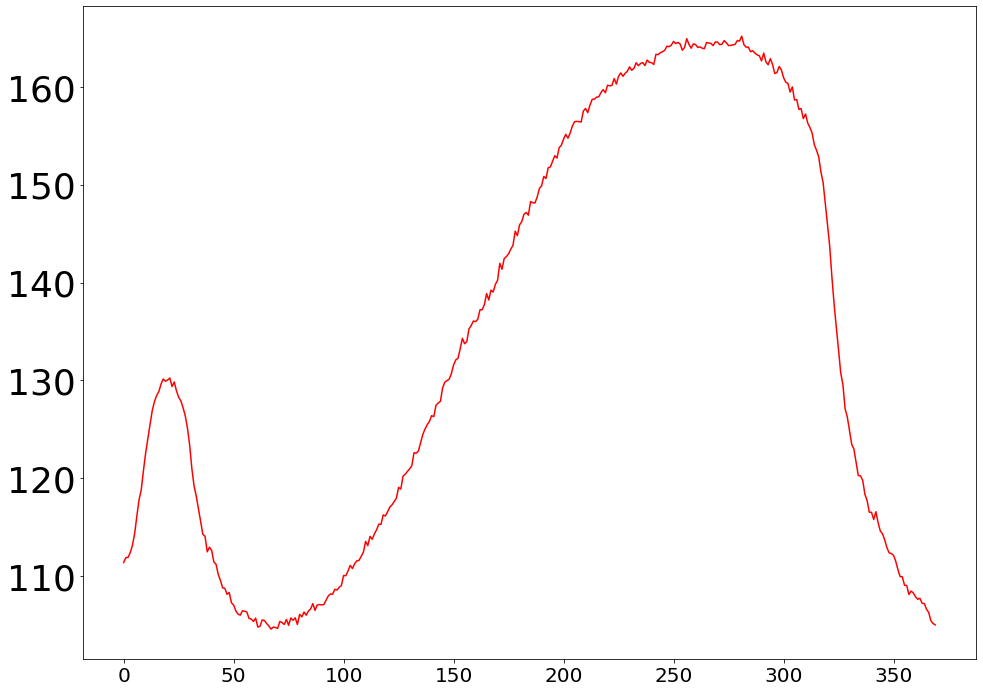

In [174]:
plt.plot(np.mean(img,axis=1),color="red")


In [185]:
272*15

4080